# Exploratory Data Analysis - ASL

Preliminary analysis of the ASL Alphabet dataset.

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install RAPIDS to run dimensionality reduction algorithms on the GPU.

This requires to use Google Colab with a GPU runtime.

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
!pip install -U kaleido

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 28, in <module>
    if ('K80' not in gpu_name):
TypeError: a bytes-like object is required, not 'str'


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_theme()

# Unzip the dataset

In [ ]:
!unzip -qu '/content/drive/MyDrive/Colab Notebooks/EEAI/Project/ASL Alphabet/ASL.zip' -d 'data'

# Load the dataset

In [ ]:
train_path = 'data/asl_alphabet_train/asl_alphabet_train'

In [ ]:
class_labels = os.listdir(train_path)
class_mapping = {i:label for i, label in enumerate(class_labels)}

Here we load only 75% of the data, in order for the whole dataset to fit into memory.

In [ ]:
batch_size = 32
split = 0.75
dataset = keras.utils.image_dataset_from_directory(train_path, batch_size=32, class_names=class_labels, validation_split=split, subset='validation', seed=42)
dataset.element_spec

Found 87000 files belonging to 29 classes.
Using 65250 files for validation.


(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
print('Number of batches: %d' % tf.data.experimental.cardinality(dataset))

Number of batches: 2040


# Preprocessing

Enable pre-fetching to increase performance

In [ ]:
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Crop to remove the blue border

In [ ]:
def crop(image, label):
    ratio = (image.shape[1] - 8) / image.shape[1]
    cropped_img = tf.image.central_crop(image, ratio)
    return cropped_img, label

In [ ]:
dataset = dataset.map(crop, num_parallel_calls=tf.data.AUTOTUNE)

Resize images to 96x96

In [ ]:
def resize(image, label):
    resized_img = tf.image.resize(image, (96, 96))
    return resized_img, label

In [ ]:
dataset = dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)

Visualize the first 9 images

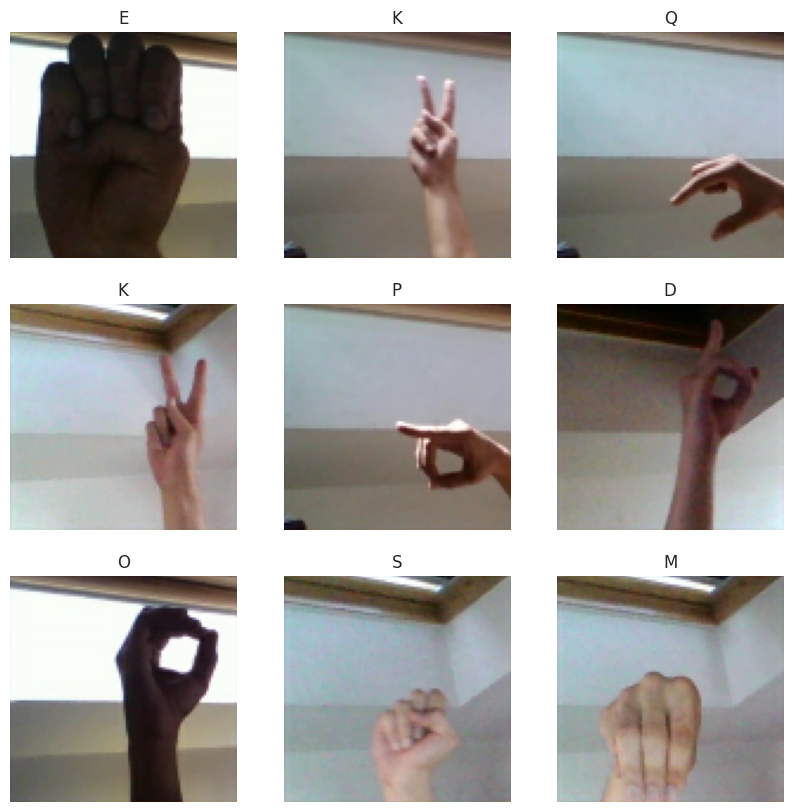

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(dataset.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype('uint8'))
    plt.title(class_labels[int(label)])
    plt.axis("off")

Convert images to gray-scale

In [ ]:
def gray_scale(image, label):
    gray_image = tf.image.rgb_to_grayscale(image)
    return gray_image, label

In [ ]:
dataset_gray = dataset.map(gray_scale, num_parallel_calls=tf.data.AUTOTUNE)
dataset_gray.element_spec

(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

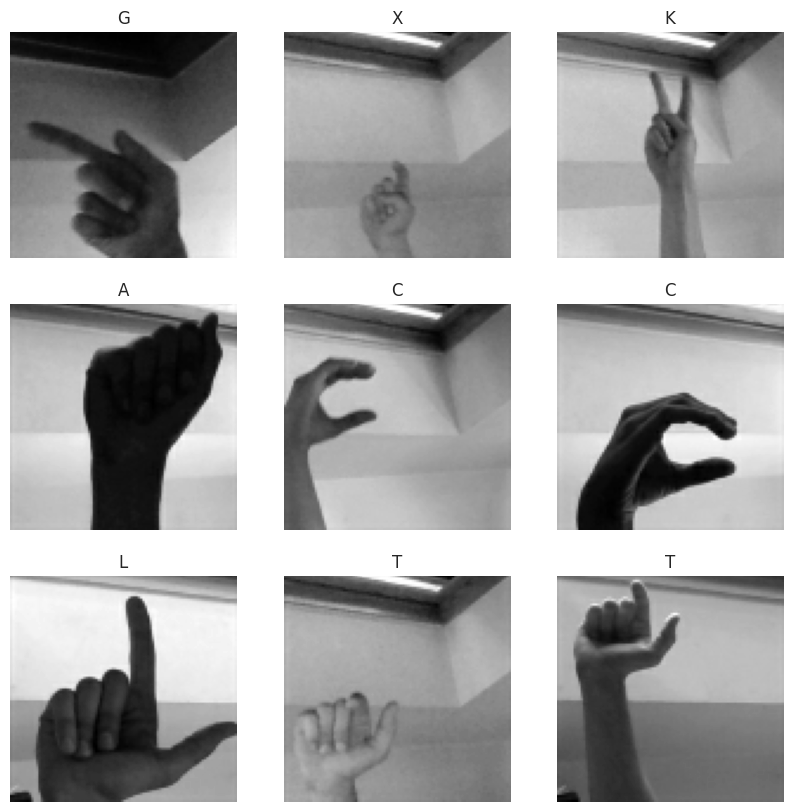

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(dataset_gray.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype('uint8'))
    plt.title(class_labels[int(label)])
    plt.set_cmap('gray')
    plt.axis("off")

# Class distribution

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
samples = []
labels = []
for x, y in tqdm(dataset_gray):
    samples.append(x)
    labels.append(y)

  0%|          | 0/2040 [00:00<?, ?it/s]

In [ ]:
samples = np.concatenate(samples, axis=0)
labels = np.concatenate(labels, axis=0)

In [ ]:
samples.shape, labels.shape

((65250, 96, 96, 1), (65250,))

In [ ]:
class_labels = [class_mapping[label] for label in labels]

In [ ]:
fig = px.histogram(x=class_labels)
fig.update_layout(
    title_text='Class distribution',
    xaxis_title_text='Class name',
    yaxis_title_text='Count',
    bargap=0.5,
    yaxis_range=[0, 2600]
)
fig.write_image('class_distribution.png', scale=3)
fig.show()

# Principal Component Analysis

Flatten the array

In [ ]:
X_flat = samples.reshape(len(samples), -1)
X_flat.shape

(43500, 9216)

In [ ]:
from cuml.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

In [ ]:
print(pca.explained_variance_ratio_)

[0.33307257 0.17525272]


In [ ]:
x, y = np.transpose(X_pca)

In [ ]:
fig = px.scatter(x=x, y=y, color=class_labels, width=1600, height=700)
fig.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    title_text='Principal Component Analysis',
    xaxis_title_text='First principal component',
    yaxis_title_text='Second principal component',
)
fig.show()
fig.write_image('pca.png', scale=2.5)

# t-SNE

In [ ]:
from cuml.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000, perplexity=10, verbose=True)
X_tsne = tsne.fit_transform(X_flat)

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning:

Starting from version 22.04, the default method of TSNE is 'fft'.



[D] [17:54:50.747765] /__w/cuml/cuml/cpp/src/tsne/tsne_runner.cuh:69 Data size = (43500, 9216) with dim = 2 perplexity = 10.000000
[D] [17:54:50.753507] /__w/cuml/cuml/cpp/src/tsne/tsne_runner.cuh:107 Getting distances.
[D] [17:55:41.599903] /__w/cuml/cuml/cpp/src/tsne/tsne_runner.cuh:142 Now normalizing distances so exp(D) doesn't explode.
[D] [17:55:41.609284] /__w/cuml/cuml/cpp/src/tsne/tsne_runner.cuh:150 Searching for optimal perplexity via bisection search.
[D] [17:55:43.922911] /__w/cuml/cuml/python/_skbuild/linux-x86_64-3.10/cmake-build/cuml/internals/logger.cxx:3194 [t-SNE] KL divergence: 0.6687796711921692


In [ ]:
print(tsne.kl_divergence_)

0.6687796711921692


In [ ]:
x, y = np.transpose(X_tsne)

In [ ]:
fig = px.scatter(x=x, y=y, color=class_labels, width=1600, height=700)
fig.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    title_text='t-distributed Stochastic Neighbor Embedding',
    xaxis_title_text='First embedding dimension',
    yaxis_title_text='Second embedding dimension',
)
fig.show()
fig.write_image('tsne.png', scale=2.5)

# Feature extraction with pre-trained CNN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm

Load the EfficientNetV2B1 model pre-trained on ImageNet, which is one of the models with the highest top-5 accuracy available on Keras and that does not take too long to compute predictions.

We will remove the classification head, since we are interested only in the feature extraction part.

In [ ]:
model = keras.applications.EfficientNetV2B1(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
    pooling="avg",
    include_preprocessing=True
)

Extract the features. Note that this time we are working on the original RGB image.

In [ ]:
features = []
labels = []
for x, y in tqdm(dataset):
  features.append(model.predict_on_batch(x))
  labels.append(y)

  0%|          | 0/2040 [00:00<?, ?it/s]

In [ ]:
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

In [ ]:
features.shape

(65250, 1280)

For each image, the model is extracting a feature vector of 1280 elements..

In [ ]:
class_labels = np.array([class_mapping[label] for label in labels])

We can use t-SNE to visualize the extracted features.

In [ ]:
classes = np.arange(30)
# classes = [0, 1, 2, 3, 4, 5]
mask = np.where(np.isin(labels, classes))

In [ ]:
from cuml.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000, perplexity=10, verbose=True)
X_tsne = tsne.fit_transform(features[mask])

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning:

Starting from version 22.04, the default method of TSNE is 'fft'.



[D] [19:17:04.344023] /__w/cuml/cuml/python/_skbuild/linux-x86_64-3.10/cmake-build/cuml/internals/logger.cxx:3194 Learning rate is adaptive. In TSNE paper, it has been shown that as n->inf, Barnes Hut works well if n_neighbors->30, learning_rate->20000, early_exaggeration->24.
[D] [19:17:04.344194] /__w/cuml/cuml/python/_skbuild/linux-x86_64-3.10/cmake-build/cuml/internals/logger.cxx:3194 cuML uses an adpative method.n_neighbors decreases to 30 as n->inf. Likewise for the other params.
[D] [19:17:04.344238] /__w/cuml/cuml/python/_skbuild/linux-x86_64-3.10/cmake-build/cuml/internals/logger.cxx:3194 New n_neighbors = 30, learning_rate = 21750.0, exaggeration = 24.0
[D] [19:17:04.344396] /__w/cuml/cuml/cpp/src/tsne/tsne_runner.cuh:69 Data size = (65250, 1280) with dim = 2 perplexity = 10.000000
[D] [19:17:04.344436] /__w/cuml/cuml/cpp/src/tsne/tsne_runner.cuh:107 Getting distances.
[D] [19:17:14.473933] /__w/cuml/cuml/cpp/src/tsne/tsne_runner.cuh:142 Now normalizing distances so exp(D) do

In [ ]:
print(f"KL divergence = {tsne.kl_divergence_}")
print(f"Number of neighbors = {tsne.n_neighbors}")

KL divergence = 0.6714761853218079
Number of neighbors = 30


In [ ]:
x, y = np.transpose(X_tsne)
fig = px.scatter(x=x, y=y, color=class_labels[mask], width=1600, height=700)
fig.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    title_text='t-distributed Stochastic Neighbor Embedding on the extracted features',
    xaxis_title_text='First embedding dimension',
    yaxis_title_text='Second embedding dimension',
)
fig.show()
fig.write_image('cnn_tsne.png', scale=2.5)